In [1]:
import pandas as pd
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

## ★ クラスタリングのクラス

In [2]:
class ScratchKMeans():
    """
    K-meansのスクラッチ実装

    Parameters
    ----------
    n_clusters : int
      クラスタ数
    n_init : int
      中心点の初期値を何回変えて計算するか
    max_iter : int
      1回の計算で最大何イテレーションするか
    tol : float
      イテレーションを終了する基準となる中心点と重心の許容誤差
    verbose : bool
      学習過程を出力する場合はTrue
    """
    def __init__(self, n_clusters, n_init, max_iter, tol, verbose=False):
        # ハイパーパラメータを属性として記録
        self.n_clusters = n_clusters
        self.n_init = n_init
        self.max_iter = max_iter
        self.tol = tol
        self.verbose = verbose
        self.centers = None
        self.sse = None
        
    def fit(self, X):
        """
        K-meansによるクラスタリングを計算
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        """
                
        # 中心点の初期値を何回変えて計算
        for n_init in range(self.n_init):
            
            # 中心点の初期値
            centers  = X[np.random.choice(X.shape[0], self.n_clusters, replace=False)]

            # クラスタへの割り当て
            clusters = allocate_cluster(X, centers)

            #verboseをTrueにした際は学習過程を出力
            if self.verbose:
                print(0)
                print(centers)        

            for i in range(self.max_iter):

                # 中心点の移動（重心の計算）
                centers  = move_center(X, clusters, centers)

                # クラスタへの割り当て
                clusters = allocate_cluster(X, centers)

                #verboseをTrueにした際は学習過程を出力
                if self.verbose:
                    print(i + 1)
                    print(centers)
                
                current_sse = calc_SSE(X, centers)
                if self.tol >= current_sse:
                    break
            
            if self.centers is None:
                self.centers = centers
                self.sse = current_sse
            elif self.sse >= current_sse:
                self.centers = centers
                self.sse = current_sse                
        
    
    def allocate_cluster(self, X, centers):

        clusters = np.zeros(X.shape[0])

        for X_row in range(X.shape[0]):
            distance = None

            for centers_row in range(centers.shape[0]):

                if distance is None:
                    distance = np.linalg.norm(X[X_row] - centers[centers_row])

                elif distance > np.linalg.norm(X[X_row] - centers[centers_row]):
                    distance = np.linalg.norm(X[X_row] - centers[centers_row])
                    clusters[X_row] = centers_row

        return clusters
    
    
    def move_center(self, X, clusters, centers):

        for centers_row in range(centers.shape[0]):
            Xi = X[clusters == centers_row]
            centers[centers_row] = np.sum(Xi, axis=0) / Xi.shape[0]

        return centers          
    
    
    def calc_SSE(self, X, centers):

        sses = np.zeros((X.shape[0], centers.shape[0]))

        for c_row in range(centers.shape[0]):
                    sses[:, c_row] = np.linalg.norm(X - centers[c_row])**2

        sse = np.min(sses, axis=1).sum()
        
        return sse
    
    
    def predict(self, X):
        """
        入力されたデータがどのクラスタに属するかを計算
        """
        y_pred = self.allocate_cluster(X, centers)
        
        return y_pred

## ★ クラスタリングのための人工データセット

クラスタリングを実験するための人工データセットを作成するコードを用意しています。
このmake_blobs関数は正解ラベルも出力してますが、今回は使用しません。使用しないことを明示するために、 _（アンダースコア） で受け取っています。
《シンプルデータセット3》

In [3]:
from sklearn.datasets import make_blobs
X, _ = make_blobs(n_samples=100, n_features=2, centers=4, cluster_std=0.5, shuffle=True, random_state=0)

In [4]:
X.shape

(100, 2)

In [5]:
X[:5]

array([[ 0.72086751,  3.71347124],
       [-1.89468423,  7.96898545],
       [ 1.35678894,  4.36462484],
       [ 1.05374379,  4.49286859],
       [ 1.59141542,  4.90497725]])

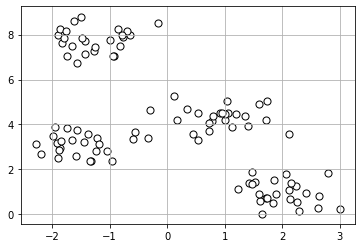

In [6]:
plt.scatter(X[:,0],X[:,1],c="w",marker="o",edgecolor="black",s=50)
plt.grid()
plt.show()

# 【問題1】中心点の初期値を決める

入力されたデータから $K$ 個の中心点 $\mu_1$ から $\mu_K$ の初期値を決めるコードを作成してください。$K$ は指定したクラスタ数です。


最もシンプルな初期値の決定方法は、データ点 $X_n$ の中からランダムに $K$ 個選ぶことです。今回はこれを実装してください。


K-meansの学習結果は中心点 $\mu$ の初期値に影響を受けます。そのため、学習時には複数個の初期値で計算を行います。

In [7]:
# クラスター数
k = 4

In [8]:
# 中心点の初期値
centers  = X[np.random.choice(X.shape[0], k, replace=False)]

In [9]:
centers

array([[ 1.40848818,  3.93270482],
       [ 0.16932115,  4.19741719],
       [-1.497272  ,  8.80022604],
       [-1.56102482,  3.77455362]])

# 【問題2】SSEを求める関数の作成

クラスタ内誤差平方和（SSE, Sum of Squared Errors）を計算する関数を作成してください。  
K-meansはこのSSEを最小化する $r_{nk}$ と $\mu_k$ を求めることが目的となります。複数個の初期値で計算したクラスタリング結果から、どれを最終的に採用するかを決める際にこのSSEを求める関数を使用します。  
$n$ : データ点のインデックス  
$k$ : クラスタのインデックス  
$X_n$ : $n$番目のデータ点  
$\mu_k$ : $k$番目の中心点  
$r_{nk}$ : データ点$X_n$がクラスタ$k$に所属していたら1、そうでなければ0

#### クラスタの割り当てと中心点の移動を繰り返す  
K-meansの学習の基本は以下の2つのフェーズを繰り返すことです。  
中心点 $\mu_k$ を固定した上で $SSE$ を最小化する クラスタの割り当て $r_{nk}$ を選ぶ。  
クラスタの割り当て $r_{nk}$ を固定した上で $SSE$ を最小化する 中心点 $\mu_k$ を選ぶ。  
最初の中心点 $\mu_k$ は問題1で作成した初期値です。  
順番に見ていきます。  

In [10]:
def calc_SSE(X, centers):
    
    sses = np.zeros((X.shape[0], centers.shape[0]))
    
    for c_row in range(centers.shape[0]):
                sses[:, c_row] = np.linalg.norm(X - centers[c_row])**2
    
    sse = np.min(sses, axis=1).sum()
    
    return sse

In [11]:
sse = calc_SSE(X, centers)
sse

87425.81210239117

# 【問題3】クラスタへの割り当て

全てのデータ点 $X_n$ を最も近い中心点 $\mu_k$ に割り当てるコードを作成してください。  
K-menasにおける 近い とは点と点のユークリッド距離が小さくなることです。ユークリッド距離とはピタゴラスの定理（三平方の定理）で求められるものですが、ベクトル $p,q$ に対しては以下の数式で表現できます。  
NumPyにはこの関数がnp.linalg.normとして用意されているため使用してください。  
numpy.linalg.norm — NumPy v1.17 Manual  
中心点 $\mu_k$ を固定した上でSSEを最小化していることになりますが、SSE自体を求める必要はありません。  

In [12]:
def allocate_cluster(X, centers):
        
    clusters = np.zeros(X.shape[0])
    
    for X_row in range(X.shape[0]):
        distance = None
        
        for centers_row in range(centers.shape[0]):
            
            if distance is None:
                distance = np.linalg.norm(X[X_row] - centers[centers_row])
                
            elif distance > np.linalg.norm(X[X_row] - centers[centers_row]):
                distance = np.linalg.norm(X[X_row] - centers[centers_row])
                clusters[X_row] = centers_row
                
    return clusters
    

In [13]:
clusters = allocate_cluster(X, centers)

In [14]:
clusters

array([0., 2., 0., 0., 0., 1., 3., 2., 1., 2., 2., 2., 2., 2., 2., 0., 0.,
       1., 3., 0., 0., 2., 3., 0., 1., 3., 1., 1., 0., 0., 0., 2., 0., 0.,
       3., 0., 2., 0., 2., 3., 0., 3., 2., 3., 3., 2., 0., 3., 1., 1., 1.,
       0., 3., 3., 3., 2., 2., 0., 0., 2., 2., 0., 0., 0., 0., 2., 3., 3.,
       0., 0., 2., 0., 0., 2., 0., 0., 3., 3., 0., 0., 0., 2., 3., 1., 0.,
       3., 0., 0., 0., 0., 0., 3., 1., 3., 3., 2., 2., 3., 2., 1.])

# 【問題4】中心点の移動

中心点 $\mu_k$ を $k$ 番目のクラスタに割り当てられる全てのデータ点 $X_n$ の平均値（重心）に移動するコードを作成してください。  
クラスタの割り当て $r_{nk}$ を固定した上でSSEを最小化していることになりますが、SSE自体を求める必要はありません。  

In [15]:
centers

array([[ 1.40848818,  3.93270482],
       [ 0.16932115,  4.19741719],
       [-1.497272  ,  8.80022604],
       [-1.56102482,  3.77455362]])

In [16]:
def move_center(X, clusters, centers):
    
    for centers_row in range(centers.shape[0]):
        Xi = X[clusters == centers_row]
        centers[centers_row] = np.sum(Xi, axis=0) / Xi.shape[0]
    
    return centers

In [17]:
centers = move_center(X, clusters, centers)
centers

array([[ 1.71949904,  2.23589351],
       [ 0.27171761,  4.15597808],
       [-1.26811733,  7.76378266],
       [-1.56883283,  3.08178097]])

# 【問題5】繰り返し

クラスタへの割り当てと中心点の移動を繰り返すことで学習を行うコードを作成してください。  
次のどれかの条件を満たしたらこれを止めます。  
繰り返しが指定した回数に到達する。（雛形では引数max_iter）  
中心点 $\mu_k$ と重心の差の合計が指定した許容値以下になる。（雛形では引数tol）  

## 繰り返しの実装
```python 
def fit(self, X):
    """
    K-meansによるクラスタリングを計算
    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
        訓練データの特徴量
    """

    # 中心点の初期値
    centers  = X[np.random.choice(X.shape[0], self.n_clusters, replace=False)]

    # クラスタへの割り当て
    clusters = allocate_cluster(X, centers)

    #verboseをTrueにした際は学習過程を出力
    if self.verbose:
        print(0)
        print(centers)        

    for i in range(self.max_iter):

        # 中心点の移動（重心の計算）
        centers  = move_center(X, clusters, centers)

        # クラスタへの割り当て
        clusters = allocate_cluster(X, centers)

        #verboseをTrueにした際は学習過程を出力
        if self.verbose:
            print(i + 1)
            print(centers)

        current_sse = calc_SSE(X, centers)
        if self.tol >= current_sse:
            break 
```

In [18]:
km0 = ScratchKMeans(n_clusters=4, n_init=1, max_iter=5, tol=0.0001, verbose=True)
km0.fit(X)

0
[[-0.78782636  7.99482384]
 [ 1.13280393  3.87673946]
 [-1.7653772   8.17625727]
 [-0.8623605   8.24721209]]
1
[[-0.98394693  7.50548802]
 [ 0.47943223  2.80251253]
 [-1.67800329  7.84380485]
 [-0.57580809  8.30467599]]
2
[[-0.98443321  7.10690585]
 [ 0.48424706  2.76904412]
 [-1.68781587  7.94562725]
 [-0.6338983   8.18055663]]
3
[[-1.09250364  6.94480117]
 [ 0.48424706  2.76904412]
 [-1.68176111  8.03388253]
 [-0.70423633  8.07595794]]
4
[[-1.12658653  6.87415791]
 [ 0.48424706  2.76904412]
 [-1.68176111  8.03388253]
 [-0.71868685  8.0052066 ]]
5
[[-1.12658653  6.87415791]
 [ 0.48424706  2.76904412]
 [-1.68176111  8.03388253]
 [-0.71868685  8.0052066 ]]


# 【問題6】異なる初期値で計算

問題5の繰り返しを、指定した回数初期値を変更して計算するコードを作成してください。回数は雛形では引数n_initで指定します。  
複数計算した中でSSEが最小になったものが最終的な学習結果となるため、その時の中心点 $\mu_k$ を保持しておきます。  

## 異なる初期値で計算
```python 
def fit(self, X):
    """
    K-meansによるクラスタリングを計算
    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
        訓練データの特徴量
    """

    # 中心点の初期値を何回変えて計算
    for n_init in range(self.n_init):

        # 中心点の初期値
        centers  = X[np.random.choice(X.shape[0], self.n_clusters, replace=False)]

        # クラスタへの割り当て
        clusters = allocate_cluster(X, centers)

        #verboseをTrueにした際は学習過程を出力
        if self.verbose:
            print(0)
            print(centers)        

        for i in range(self.max_iter):

            # 中心点の移動（重心の計算）
            centers  = move_center(X, clusters, centers)

            # クラスタへの割り当て
            clusters = allocate_cluster(X, centers)

            #verboseをTrueにした際は学習過程を出力
            if self.verbose:
                print(i + 1)
                print(centers)

            current_sse = calc_SSE(X, centers)
            if self.tol >= current_sse:
                break

        if self.centers is None:
            self.centers = centers
            self.sse = current_sse
        elif self.sse >= current_sse:
            self.centers = centers
            self.sse = current_sse
```

In [19]:
km1 = ScratchKMeans(n_clusters=4, n_init=2, max_iter=3, tol=0.0001, verbose=True)
km1.fit(X)

0
[[-1.33869125  2.36818187]
 [ 2.06051753  1.79059891]
 [-1.87418794  2.84306499]
 [ 1.4726926   1.3480769 ]]
1
[[-0.49721306  3.29080179]
 [ 1.55605228  3.37271107]
 [-1.39234555  5.95713239]
 [ 1.80170393  0.8449765 ]]
2
[[-1.25217095  3.27736375]
 [ 1.11752572  4.28627241]
 [-1.21460762  7.66822082]
 [ 1.99186903  0.96561071]]
3
[[-1.47935679  3.11716896]
 [ 0.92578447  4.32475792]
 [-1.26811733  7.76378266]
 [ 1.99186903  0.96561071]]
0
[[ 1.24016835  1.12905479]
 [-1.26041884  7.46644456]
 [ 1.89949126  0.92574633]
 [ 1.42002502  1.38236201]]
1
[[-1.48467917  2.73950363]
 [-1.11702754  7.03805554]
 [ 2.15339145  0.76038473]
 [ 0.73509371  3.57488958]]
2
[[-1.52702451  3.10579592]
 [-1.26811733  7.76378266]
 [ 1.99186903  0.96561071]
 [ 0.87728     4.28881038]]
3
[[-1.47935679  3.11716896]
 [-1.26811733  7.76378266]
 [ 1.99186903  0.96561071]
 [ 0.92578447  4.32475792]]


# 【問題7】推定

新たなデータに対してどのクラスタに所属するかの推定の際は、学習時の1つ目のフェーズと同じことを行います。  
データ点 $X_n$ と学習で決まった中心点 $\mu_k$ に対し、 $SSE$ を最小化する $r_{nk}$ を選ぶ。  
具体的には次のことです。  
データ点 $X_n$ を最も近い $\mu_k$ に割り当てる。  

In [20]:
km2 = ScratchKMeans(n_clusters=4, n_init=4, max_iter=5, tol=0.0001, verbose=False)
km2.fit(X)
y_pred = km2.predict(X)
y_pred

array([1., 2., 1., 1., 1., 1., 3., 2., 1., 2., 2., 2., 2., 2., 2., 0., 0.,
       1., 3., 0., 0., 2., 3., 0., 1., 3., 1., 1., 0., 0., 0., 2., 0., 0.,
       3., 1., 2., 0., 2., 3., 1., 3., 2., 3., 3., 2., 0., 3., 1., 1., 1.,
       0., 3., 3., 3., 2., 2., 0., 0., 2., 2., 0., 0., 1., 0., 2., 3., 3.,
       0., 1., 2., 0., 1., 2., 1., 1., 3., 3., 0., 0., 0., 2., 3., 1., 0.,
       3., 0., 0., 1., 1., 1., 3., 1., 3., 3., 2., 2., 3., 2., 1.])

# 【問題8】エルボー法の実装

K-meansにおいて中心点の個数 $k$ は人為的に決める必要がありますが、その判断方法としてエルボー法があります。エルボー法により中心点の個数 $k$ を検討するためのコードを作成してください。  
SSEを縦軸、クラスタ数 $k$ を横軸にした折れ線グラフを表示します。このためにK-meansのインスタンスからはSSEを取得できるようにしてください。  

In [54]:
sse = np.zeros(8)
for n in range(1, 9):
    km = ScratchKMeans(n_clusters=n, n_init=4, max_iter=20, tol=0.000007, verbose=False)
    km.fit(X)
    sse[n-1]=km.sse

In [55]:
sse.shape

(8,)

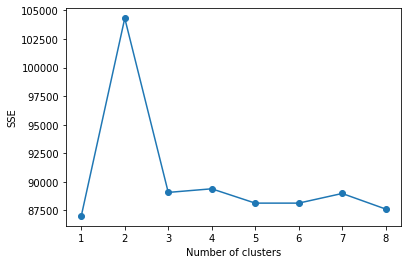

In [56]:
plt.plot(range(1,9),sse,marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()

# 【問題9】（アドバンス課題）シルエット図

$k$ を決める助けになるものとしてシルエット図もあります。シルエット図を表示するコードを作成してください。  
Matplotlibを使い図を表示するコードは用意しました。以下を与えてください。  
silhouette_vals : shape(n_samples,)のndarray、各データ点のシルエット係数  
silhouette_avg : float、シルエット係数の平均値  
y_km : shape(n_samples,)のndarray、各データ点のクラスタラベル名  
cluster_labels : list、クラスタのラベル名のリスト  
n_clusters : int、クラスタ数  
$n$ 番目のデータ点に対するシルエット係数 $s_n$ は以下の数式でを求められます。この数式を実装し、シルエット図を確認してください。  
$a_n$ : 凝集度。同じクラスタ内の他のデータ点との距離の平均値。  
$b_n$ : 乖離度。最も近い他のクラスタ内の全てのデータ点との距離の平均値。  
乖離度 $b$ が大きく、凝集度 $a$ が小さい時が理想的であり、シルエット係数 $s$ は1に近くなります。  
《シルエット図を表示するためのコード》  

import math
def silhouette_coefficient(clusters, df):
    a_same = []
    b_diff = []
    for i, j in enumerate(clusters):
        vec1 = df.iloc[i, :].values
        for k, l in enumerate(clusters):
            if i < k:
                vec2 = df.iloc[k, :].values
                dist = 0.
                for v1, v2 in zip(vec1, vec2):
                    dist += (v1 - v2) ** 2
                dist = math.sqrt(dist)
                if j == l: # same cluster
                    a_same.append(dist)
                else: # different cluster
                    b_diff.append(dist)
    a = sum(a_same) / len(a_same)
    b = sum(b_diff) / len(b_diff)
    return (b - a) / max(b, a)

# 【問題10】クラスタ数kの選択

最適だと思われるクラスタ数 $k$ を選択してください。エルボー法やシルエット図を活用する他、人間が後々どう利用したいのかも選択に関わってきます。選択した上で、なぜそれを選んだか説明してください。

In [24]:
# trainデータを読み込む
data = pd.read_csv('Wholesale customers data.csv')
data.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [25]:
data = df[['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']]
data.head()

NameError: name 'df' is not defined

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
pca = PCA(n_components=None)
pca = pca.fit(data)
var_exp = pca.explained_variance_ratio_
cum_var_exp = np.cumsum(var_exp)
print(cum_var_exp)
plt.bar(range(1,7), var_exp, alpha=0.5, align='center', label='individual explained variance')
plt.step(range(1,7), cum_var_exp, where='mid', label='cumulative expalined variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.hlines(0.7, 0, 6,  "blue", linestyles='dashed')
plt.legend(loc='best')
plt.grid()
plt.show()

# 【問題11】既知のグループとの比較

RegionとChannelはK-meansに使用しなかったが、これれらは既知のグループです。クラスタとこれら既知のグループがどう違うかを確認し、説明してください。まずはそれぞれを可視化してください。

# 【問題12】卸売業者にとって有益な情報

卸売業者にとって有益な情報を探し出し文章にまとめてください。  
《ヒント》  
前処理を行う前のデータを使い、各クラスタの要約統計量を見るなどしてみましょう。また、PCAで次元削減したデータに対してK-meansを使用しましたが、6個の特徴量をそのまま使ったり、一部の特徴量のみを使ったりということも試してみてください。既知のグループとの比較結果も参考にしてください。  
条件ごとにデータを見る際にはPandasのgroupbyが便利です。  